# <font color='black'> Регрессионный анализ панельных данных и каузальность, 2026 </font>
## <font color='black'> Практическое занятие 4. Приведение данных к стационарным  </font>

На предыдущем занятии мы говорили, что для оценивания регрессионных моделей с лагированными переменными важно предварительно проверить ряд зависимой переменной и предикторов на стационарность. Если ряд нестационарный, тогда распределение интересующей нас переменной будет меняться со временем, что приводит к невозможности опираться на результаты оценивания модели и результаты тестирования значимости

Мы проверяли данные на стационарность посредством теста Дики--Фуллера. Нулевая гипотеза в этом тесте: ряд нестационарный. Соответственно, если p-value достаточно мал, то нулевая гипотеза отвергается, и ряд является стационарным. Но что делать в обратном случае, если есть свидетельства в пользу нестационарности? В таком случае, до того, как Вы приступите к оцениванию моделей с лагированными переменными, преобразуйте данные. После преобразования проверьте опять же посредством теста Дики--Фуллера, можно ли теперь говорить о стационарности

Ниже рассмотрим наиболее распространенные преобразования данных в стационарные на примере нескольких массивов

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

Первый массив, который мы загрузим, это массив "daily_reddit_score.csv". Этот массив содержит данные платформы Reddit, на которой пользователи размещают ссылки на какую-либо понравившуюся информацию в интернете, обсуждают ее и голосуют за контент. В массиве представлены значения суммарного рейтинга постов за каждый день начиная 30 апреля 2025 г. и заканчивая 26 октября 2025 г. (переменная score).

Проанализируем этот ряд на нестационарность. Можем предположить, что в какие-то дни активность большая, в какие-то -- наоборот, снижается, со временем популярность тем меняется, кроме этого, скорее всего, есть определенные закономерности изменения динамики за неделю (циклы):

In [2]:
reddit = pd.read_csv('daily_reddit_score.csv')
reddit.head()

,date,score
0,2025-04-30,8439
1,2025-05-01,29708
2,2025-05-02,16657
3,2025-05-03,20575
4,2025-05-04,15026


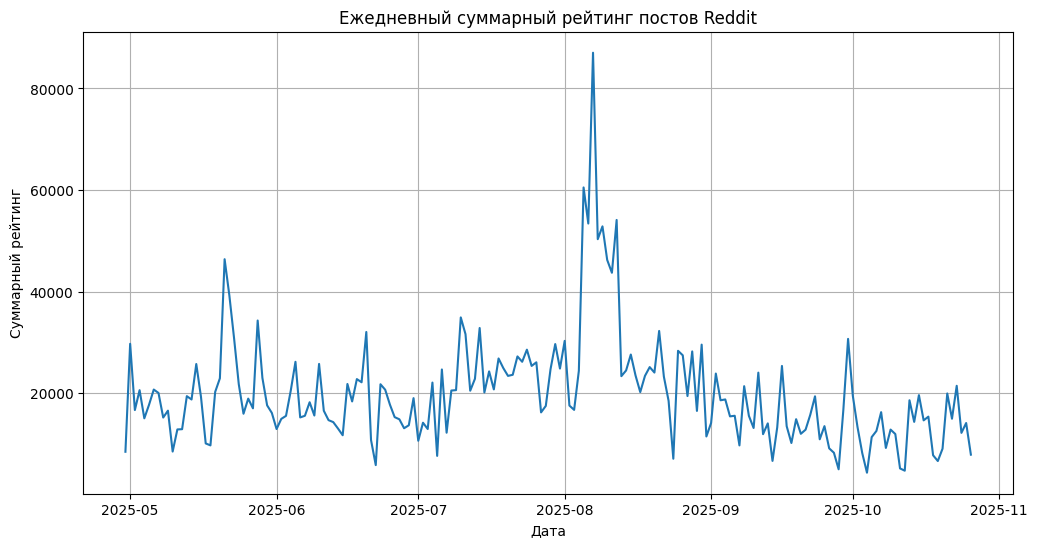

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(reddit['date']), reddit['score'])
plt.title('Ежедневный суммарный рейтинг постов Reddit')
plt.xlabel('Дата')
plt.ylabel('Суммарный рейтинг')
plt.grid(True)
plt.show()

На графике динамики переменной score видно, что меняется как уровень среднего, так и дисперсия со временем, что свидетельствует о нестационарности данных. Проверим данные на нестационарность формально при помощи теста Дики--Фуллера:

In [4]:
result = adfuller(reddit['score'].dropna())
print('Statistic:', result[0])
print('p-value:', result[1])

Statistic: -1.9804236337870837
p-value: 0.2952220625037853


По результатам можно сказать, что нулевая гипотеза не отвергается, следовательно, указанный ряд нестационарный, как мы и предположили по графику выше.

Построим еще графики ACF и PACF для исходных нестационарных данных.

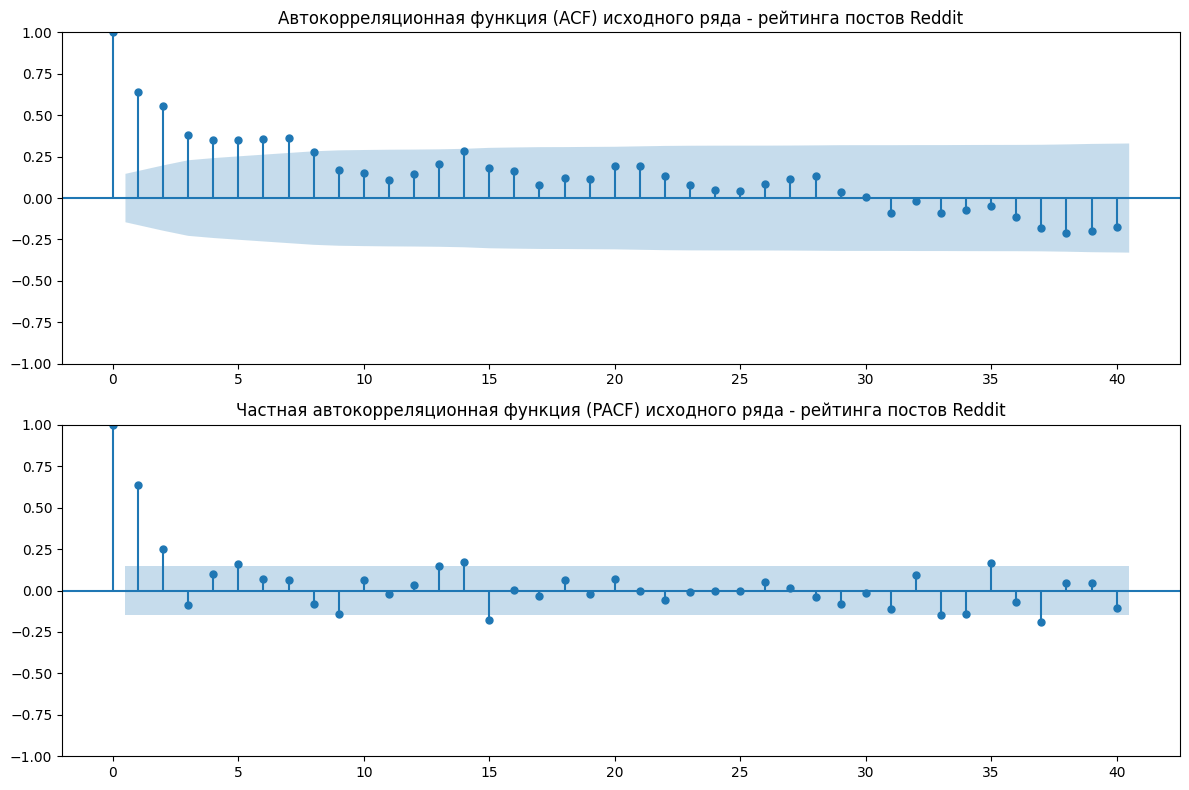

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(reddit['score'], lags=40, ax=ax1)
ax1.set_title('Автокорреляционная функция (ACF) исходного ряда - рейтинга постов Reddit')

plot_pacf(reddit['score'], lags=40, ax=ax2)
ax2.set_title('Частная автокорреляционная функция (PACF) исходного ряда - рейтинга постов Reddit')

plt.tight_layout()
plt.show()

Для преобразования ряда в стационарность возьмем первую разность.

$\Delta y_t = y_t - y_{t-1}$,
где $y_t$ — значение ряда в момент времени t, а $y_{t-1}$ — значение ряда в предыдущий временной период. То есть, первая разность показывает, на сколько изменился показатель по сравнению с предыдущим периодом

In [6]:
reddit['score_diff'] = reddit['score'].diff()

In [7]:
result2 = adfuller(reddit['score_diff'].dropna())
print('Statistic:', result2[0])
print('p-value:', result2[1])

Statistic: -4.711846946324358
p-value: 7.994462176215545e-05


В дополнении к результатам формального теста построим график динамики, но теперь для первой разности:

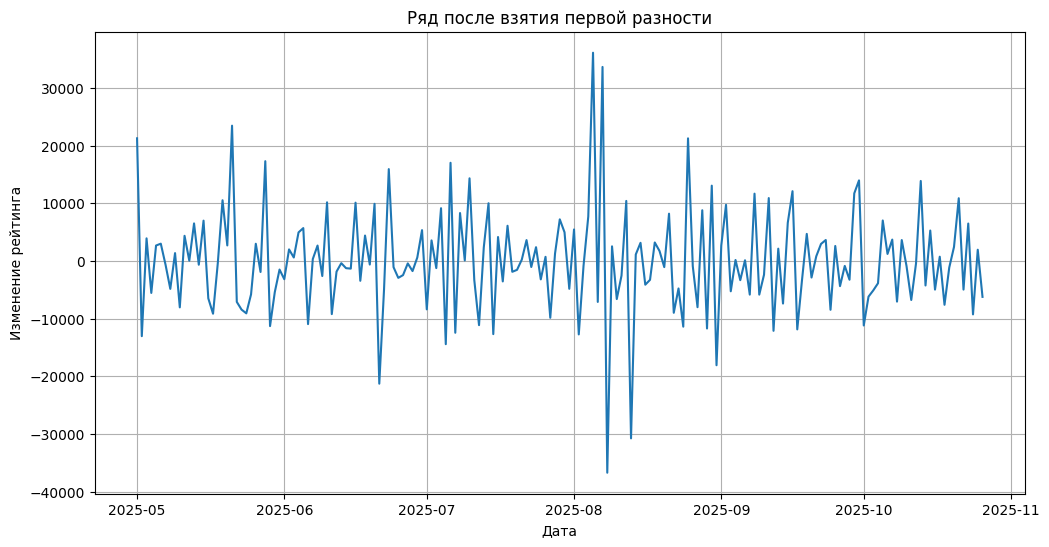

In [8]:
reddit['score_diff'] = reddit['score'].diff()

df_diff = reddit.dropna(subset=['score_diff'])

plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(df_diff['date']), df_diff['score_diff'])
plt.title('Ряд после взятия первой разности')
plt.xlabel('Дата')
plt.ylabel('Изменение рейтинга')
plt.grid(True)
plt.show()

Мы видим, что среднее теперь более стабильно, колеблется относительно 0. Однако до сих пор есть скачки в дисперсии

Поэтому здесь более целесообразным будет логарифмировать данные перед взятием разности

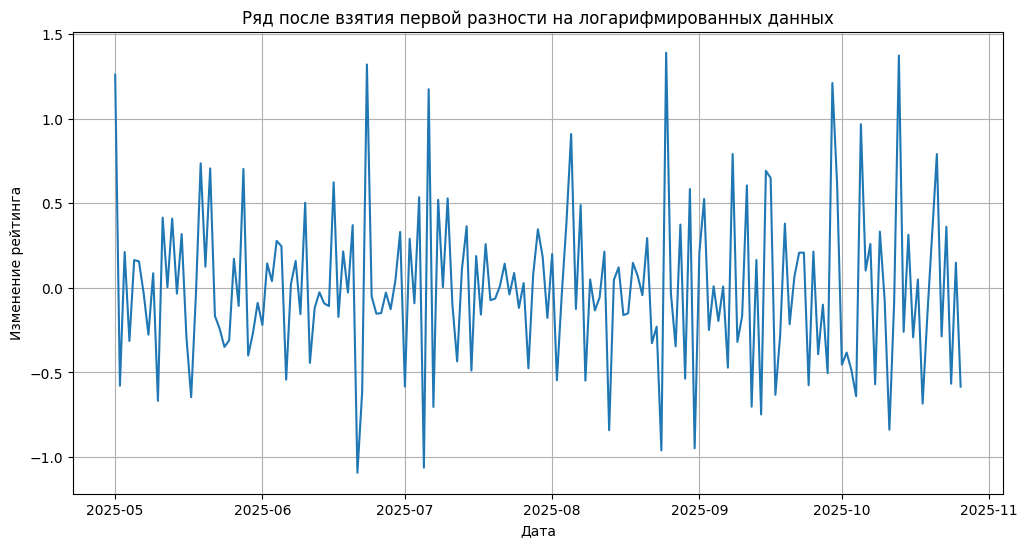

In [9]:
reddit['score_log'] = np.log(reddit['score'])
reddit['score_diff_log'] = reddit['score_log'].diff()

plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(reddit['date']), reddit['score_diff_log'])
plt.title('Ряд после взятия первой разности на логарифмированных данных')
plt.xlabel('Дата')
plt.ylabel('Изменение рейтинга')
plt.grid(True)
plt.show()

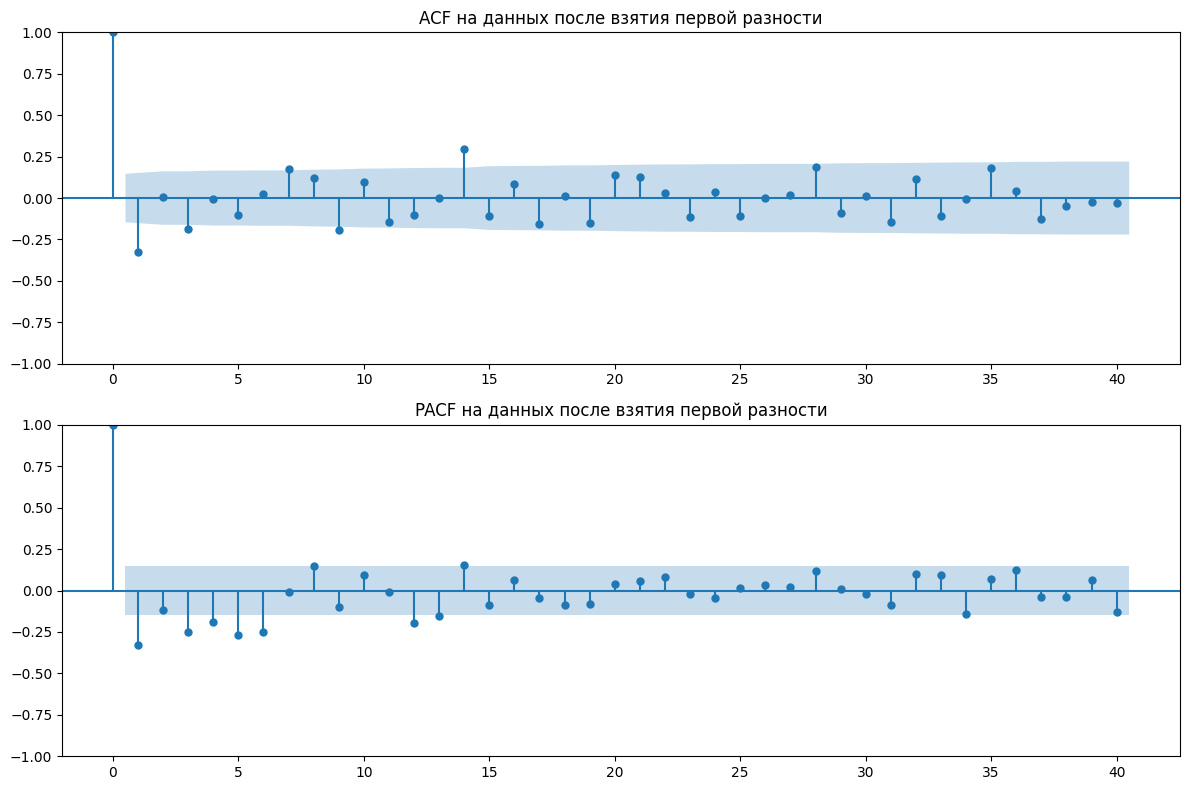

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(reddit['score_diff_log'].dropna(), lags=40, ax=ax1)
ax1.set_title('ACF на данных после взятия первой разности')
plot_pacf(reddit['score_diff_log'].dropna(), lags=40, ax=ax2)
ax2.set_title('PACF на данных после взятия первой разности')
plt.tight_layout()
plt.show()

Далее рассмотрим классический пример данных, довольно часто приводимый в учебниках по анализу временных рядов - массив "passengers.csv". В этом массиве приводятся данные ежемесячного количества пассажиров международных авиалиний США в период с января 1949 по декабрь 1960 г.  

In [11]:
passengers = pd.read_csv('passengers.csv', skiprows=1, names=['Month', 'Passengers'])
passengers.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


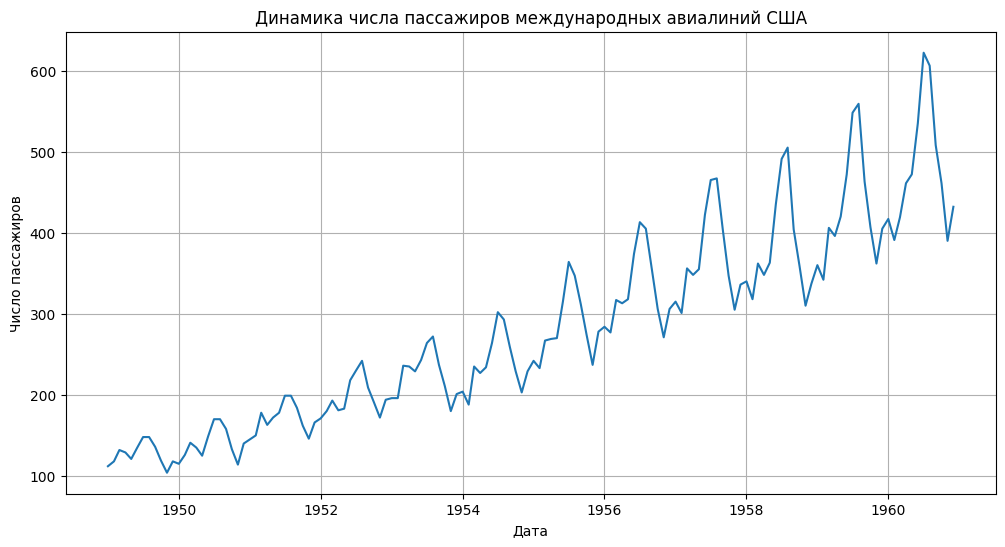

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(passengers['Month']), passengers['Passengers'])
plt.title('Динамика числа пассажиров международных авиалиний США')
plt.xlabel('Дата')
plt.ylabel('Число пассажиров')
plt.grid(True)
plt.show()

Эти данные - хорошая иллюстрация тренда, сезонности и непостоянной дисперсии

In [13]:
result3 = adfuller(passengers['Passengers'].dropna())
print('Statistic:', result3[0])
print('p-value:', result3[1])

Statistic: 0.8153688792060498
p-value: 0.991880243437641


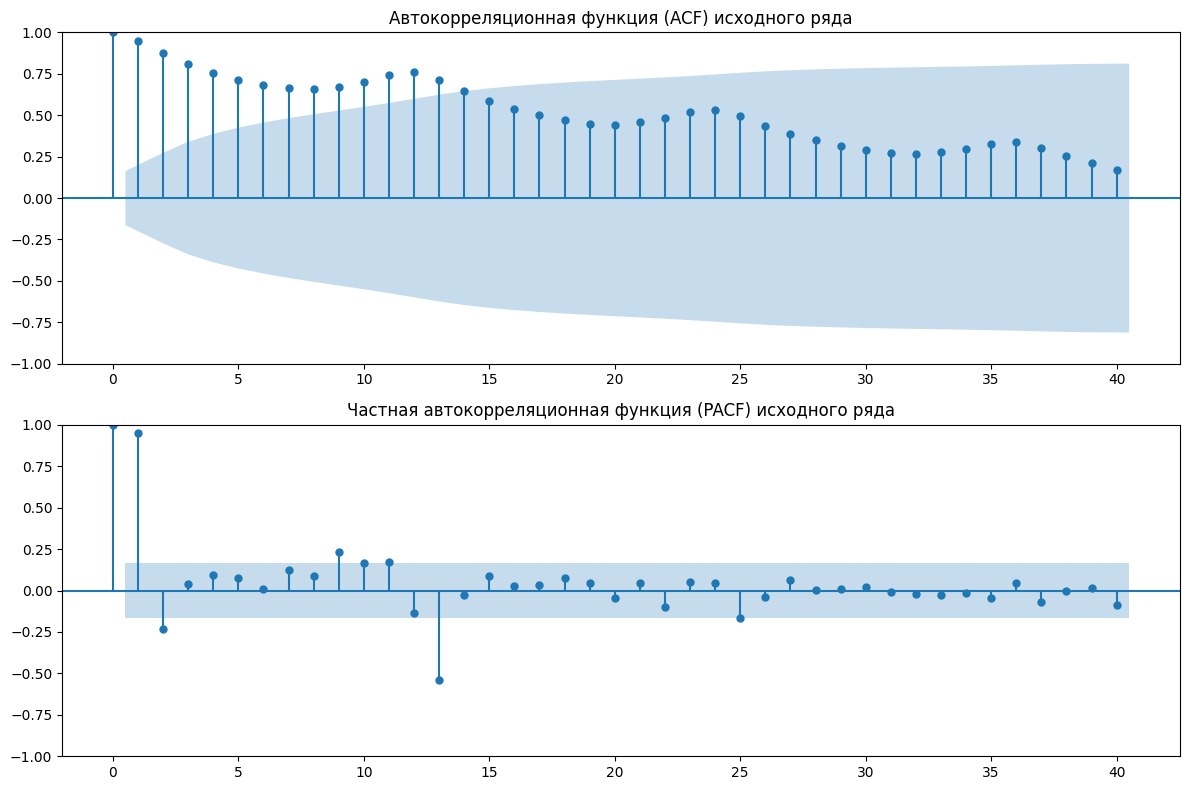

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(passengers['Passengers'], lags=40, ax=ax1)
ax1.set_title('Автокорреляционная функция (ACF) исходного ряда')

plot_pacf(passengers['Passengers'], lags=40, ax=ax2)
ax2.set_title('Частная автокорреляционная функция (PACF) исходного ряда')

plt.tight_layout()
plt.show()

Попробуем для начала просто первую разность и убедимся, что первая разность в данном случае не способна преобразовать данные в стационарные:

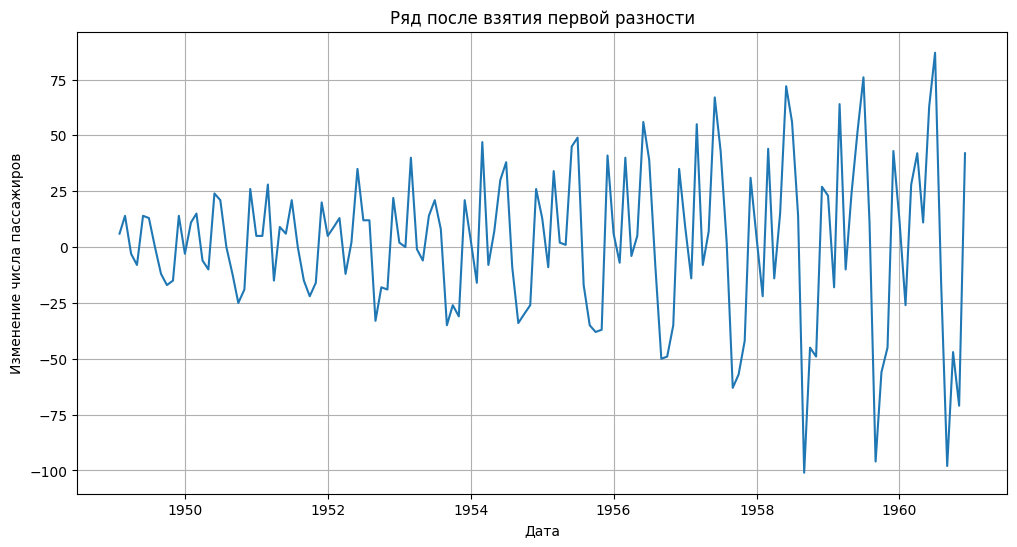

In [15]:
passengers['Passengers_diff'] = passengers['Passengers'].diff()

plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(passengers['Month']), passengers['Passengers_diff'])
plt.title('Ряд после взятия первой разности')
plt.xlabel('Дата')
plt.ylabel('Изменение числа пассажиров')
plt.grid(True)
plt.show()

In [16]:
result4 = adfuller(passengers['Passengers_diff'].dropna())
print('Statistic:', result4[0])
print('p-value:', result4[1])

Statistic: -2.8292668241700047
p-value: 0.05421329028382478


Используем преобразование: логарифмирование + взятие первой разности. Кроме этого, еще удалим сезонность через взятие сезонной разности с лагом в 12 месяцев:  

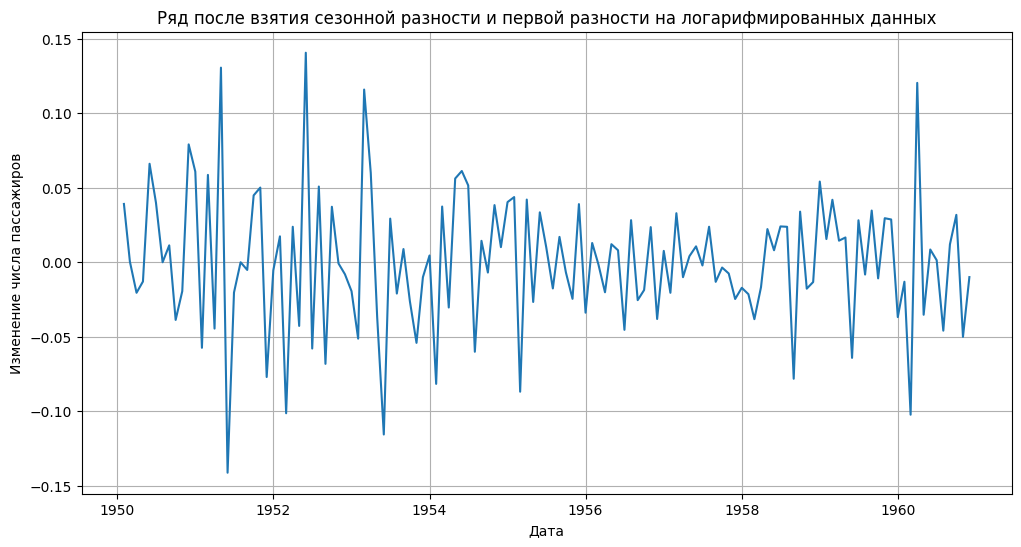

In [17]:
passengers['pas_log'] = np.log(passengers['Passengers'])
passengers['pas_diff12_log'] = passengers['pas_log'].diff(12)
passengers['pas_dif_final'] = passengers['pas_diff12_log'].diff()

plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(passengers['Month']), passengers['pas_dif_final'])
plt.title('Ряд после взятия сезонной разности и первой разности на логарифмированных данных')
plt.xlabel('Дата')
plt.ylabel('Изменение числа пассажиров')
plt.grid(True)
plt.show()

In [18]:
result5 = adfuller(passengers['pas_dif_final'].dropna())
print('Statistic:', result5[0])
print('p-value:', result5[1])

Statistic: -4.4433249418311425
p-value: 0.00024859123113838495


Однако возникает вопрос, что делать, если исходные данные содержат отрицательные значения, и взять логарифм невозможно?

In [19]:
temp = pd.read_csv('moscow_temp.csv')
temp.head()

,date,temperature
0,2023-01-01,2.3
1,2023-01-02,-1.2
2,2023-01-03,-1.7
3,2023-01-04,-3.3
4,2023-01-05,-7.3


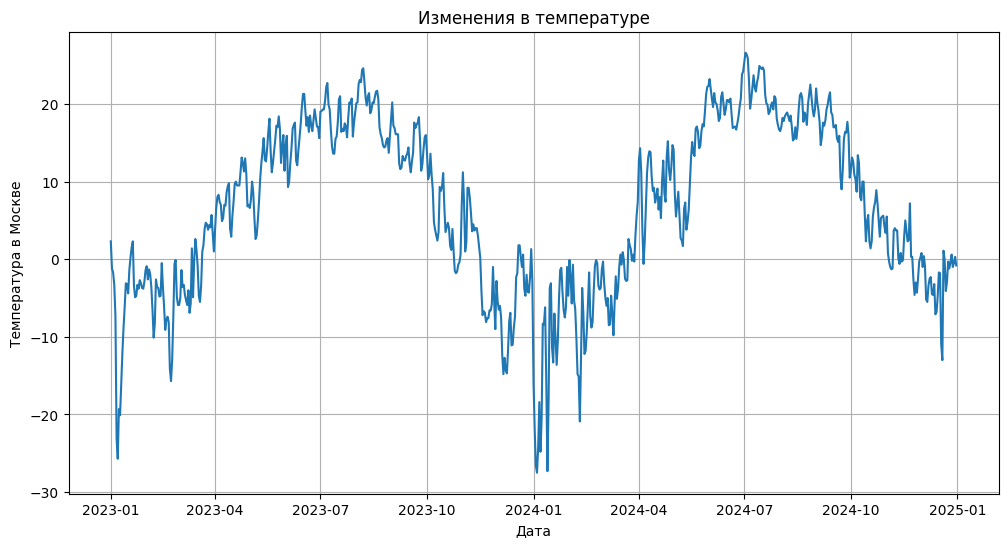

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(temp['date']), temp['temperature'])
plt.title('Изменения в температуре')
plt.xlabel('Дата')
plt.ylabel('Температура в Москве')
plt.grid(True)
plt.show()

In [21]:
result6 = adfuller(temp['temperature'].dropna())
print('Statistic:', result6[0])
print('p-value:', result6[1])

Statistic: -2.6814188806714663
p-value: 0.07730917395594608


Здесь можно использовать следующие стратегии работы с отрицательными значениями:

1) сдвинуть ряд на разумную константу такую, чтобы избавиться от отрицательных значений, а далее - уже логарифмировать
:
2) использовать функцию обратного гиперболического синуса:

$$\operatorname{asinh}(x) = \ln\left(x + \sqrt{x^2 + 1}\right)$$

In [22]:
delta = abs(temp['temperature'].min()) + 1
temp['temp_shifted'] = temp['temperature'] + delta

temp['temp_shifted_log'] = np.log(temp['temp_shifted'])

temp['temp_shifted_log_seasonal'] = temp['temp_shifted_log'].diff(365)

temp['temp_final'] = temp['temp_shifted_log_seasonal'].diff()

Либо можно сразу посчитать функцию обратного гиперболического синуса без дополнительного логарифмирования:

In [23]:
temp['temp_asinh'] = np.arcsinh(temp['temperature'])

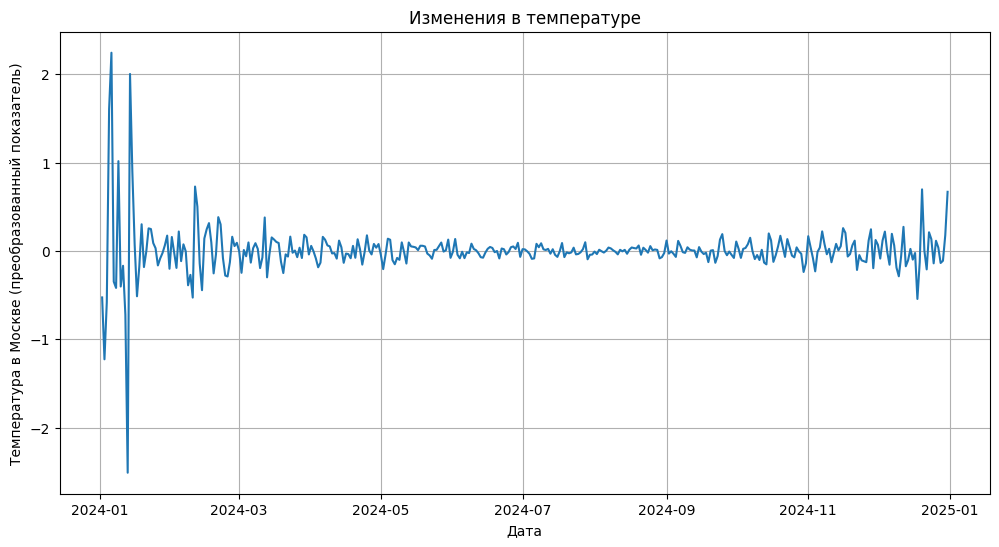

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(temp['date']), temp['temp_final'])
plt.title('Изменения в температуре')
plt.xlabel('Дата')
plt.ylabel('Температура в Москве (преобразованный показатель)')
plt.grid(True)
plt.show()

In [25]:
result7 = adfuller(temp['temp_final'].dropna())
print('Statistic:', result7[0])
print('p-value:', result7[1])

Statistic: -7.490211041690224
p-value: 4.526438935844355e-11
